<a href="https://colab.research.google.com/github/tamaricki/Forest_Cover_Type_Classification_Model/blob/main/ForestCoverType_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Forest Cover Classification Project ###
 
Project goal is to predict forest cover type (the most common kind of tree cover) based only on cartographic variables. The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. The covertypes are the following:

- Spruce/Fir (type 1)
- Lodgepole Pine (type 2)
- Ponderosa Pine (type 3)
- Cottonwood/Willow (type 4)
- Aspen (type 5)
- Douglas-fir (type 6)
- Krummholz (type 7)

It contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.
This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so existing forest cover types are mainly a result of ecological processes rather than forest management practices.

More information about attributes in the data set can be found on the <a href='https://archive.ics.uci.edu/ml/datasets/covertype'> UCI Machine Learning Repository</a> page: 
* A Hillshade is a grayscale 3D representation of the surface, with the sun's relative position taken into account for shading the image. This function uses the altitude and azimuth properties to specify the sun's position.
* Azimuth or aspect - The vector from an observer (origin) to a point of interest is projected perpendicularly onto a reference plane; the angle between the projected vector and a reference vector on the reference plane is called the azimuth.
* Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation 
* Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation. Wilderness Area “an area where the earth and its community of life are untrammeled by man, where man himself is a visitor who does not remain.” Wilderness areas in this data set are :  Rawah (area 1), Neota (area 2) Comanche Peak (area 3), and Cache la Poudre (area 4)




In [1]:
import io
from google.colab import files
up = files.upload()

Saving cover_data.csv to cover_data.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
data = pd.read_csv(io.BytesIO(up['cover_data.csv']))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [4]:
data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [5]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


Labels for which will Project build predition model are in the last model 'class' 

In [5]:
balance_check = data['class'].value_counts().reset_index()
balance_check.sort_values(by='index')

,index,class
1,1,211840
0,2,283301
2,3,35754
6,4,2747
5,5,9493
4,6,17367
3,7,20510


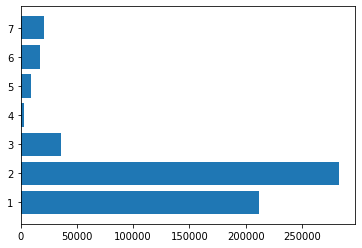

In [6]:
types = ['Spruce/Fir','Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
plt.barh(balance_check['index'], balance_check['class'])
plt.show()

The data set is quite imbalanced meaning that model accuracy might not reflect the true model performance , and that we would need to look deeper in the other metrics like recall, F1 , or resample the set . 

### Convert Class column to category ###
then it can be checked the distribution of cover type depending on elevation?
...And maybe distribution per area? for that we can rename the column names into area names. do we need new df to repivot the columns ?

In [7]:
real_names = {'Wilderness_Area1':'Rawah', 'Wilderness_Area2':'Neota', 'Wilderness_Area3': 'Comanche Peak', 'Wilderness_Area4': 'Cache la Poudre'}
data.rename(columns=real_names, inplace = True)


In [8]:
areas = pd.pivot_table(data, values = ['Rawah', 'Neota', 'Comanche Peak', 'Cache la Poudre'], index = 'class', aggfunc = np.sum)
areas

,Cache la Poudre,Comanche Peak,Neota,Rawah
class,,,,
1,0,87528,18595,105717
2,3026,125093,8985,146197
3,21454,14300,0,0
4,2747,0,0,0
5,0,5712,0,3781
6,9741,7626,0,0
7,0,13105,2304,5101


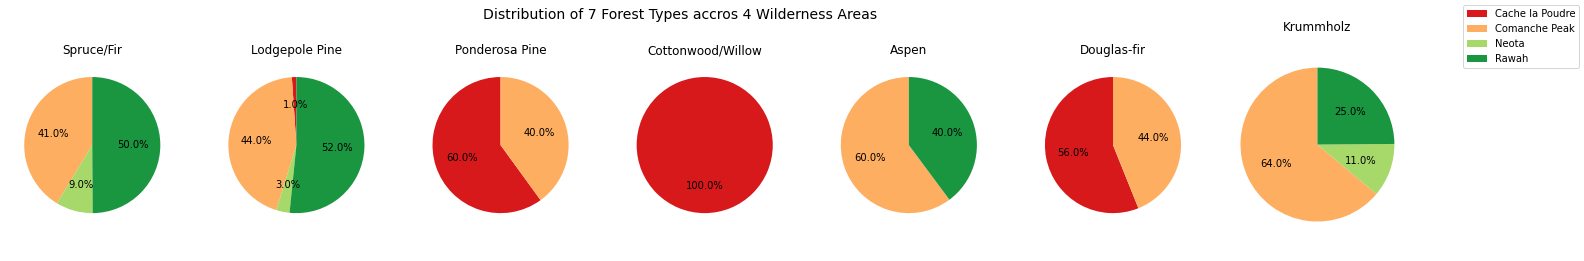

In [9]:
labels = areas.columns

colors = ['#d7191c','#fdae61','#a6d96a','#1a9641']
f, ax = plt.subplots(1, 7, figsize=(25,4))
i = 0
for a in range(len(ax)):
  ax[a].pie(areas.iloc[a, :], autopct = lambda p: '{:.1f}%'.format(round(p)) if p>0 else '',startangle = 90, colors= colors)
  ax[a].title.set_text(types[a])
  plt.axis('equal')
f.legend(labels)
f.suptitle('Distribution of 7 Forest Types accros 4 Wilderness Areas ', fontsize = 14)
plt.axis('equal')
plt.show() 


Forest type present in all 4 areas is Lodgepole Pine, although Willow has share of app 1%. Areas Cache la Poudre, Comanche Peak as most dominant forest type have Ponderosa Pine, Cottonwood/Willow and Douglas-fir. Reason for that could be the same elevation ranges ,  or something else. 
Comanche Peak has most of the forest types, 6 from 7, only Cottonwood/Willow type is missing, and this type of forest is dominant in Cache la Poudre. Could be that size of area has impact on that ? 


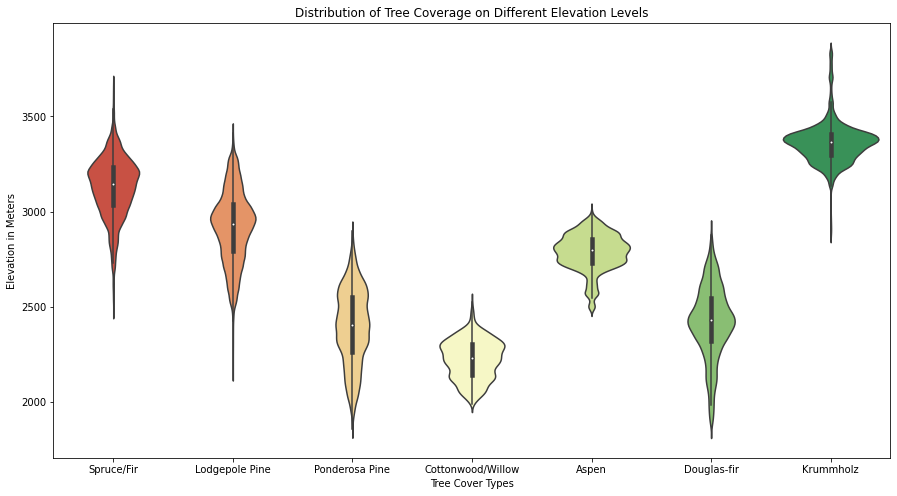

In [10]:
from pandas.core.indexes import category
data['class'] = data['class'].astype('category')
ax, fig = plt.subplots(figsize = (15,8))
sns.violinplot(data = data, x = 'class', y = 'Elevation', palette ='RdYlGn')
fig.set_xticklabels(types)
plt.title('Distribution of Tree Coverage on Different Elevation Levels')
plt.ylabel('Elevation in Meters')
plt.xlabel('Tree Cover Types')
plt.show()

It seems like that Krummholz together with Spruce and Lodgepole pine,  grows on highes mountains, having more than 3000m. Other species grow in areas below 3000m elevation. None of the species seems to be normaly distributed, but most close to normal distribution is Lodgepole Pine, although with quite some outliers. Least outliers are visible  for Willow, it means that type only can grow in areas not higher than 2500m.

### Data Preparation ###

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


In [12]:
features = data.drop(columns = 'class')
labels = data['class']
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify = labels, random_state= 29)

#normalize the numeric features
normalizer = StandardScaler()
x_train_scaled = normalizer.fit_transform(x_train)
x_test_scaled = normalizer.transform(x_test)



In [74]:
# building the model
#Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) 
#and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).
model = Sequential()
model.add(InputLayer(input_shape = (x_train_scaled.shape[1])))
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation = 'relu'))
model.add(Dense(42, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(8, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()
x_train_scaled.shape

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 120)               6600      
                                                                 
 dense_37 (Dense)            (None, 84)                10164     
                                                                 
 dense_38 (Dense)            (None, 42)                3570      
                                                                 
 dense_39 (Dense)            (None, 20)                860       
                                                                 
 dense_40 (Dense)            (None, 8)                 168       
                                                                 
Total params: 21,362
Trainable params: 21,362
Non-trainable params: 0
_________________________________________________________________


(464809, 54)

In [75]:
#fiting the model
no_epochs = 188
batch_size = 1200
stop = EarlyStopping(patience = 5, monitor = 'val_accuracy' )
hist = model.fit(x_train_scaled, y_train, epochs = no_epochs, batch_size = batch_size, validation_split= 0.1, verbose = 1, callbacks=[stop]) 

Epoch 1/188
349/349 [==============================] - 4s 9ms/step - loss: 0.7503 - accuracy: 0.7084 - val_loss: 0.5589 - val_accuracy: 0.7659
Epoch 2/188
349/349 [==============================] - 2s 7ms/step - loss: 0.5227 - accuracy: 0.7799 - val_loss: 0.4885 - val_accuracy: 0.7971
Epoch 3/188
349/349 [==============================] - 2s 7ms/step - loss: 0.4680 - accuracy: 0.8042 - val_loss: 0.4472 - val_accuracy: 0.8152
Epoch 4/188
349/349 [==============================] - 2s 7ms/step - loss: 0.4346 - accuracy: 0.8183 - val_loss: 0.4196 - val_accuracy: 0.8258
Epoch 5/188
349/349 [==============================] - 2s 7ms/step - loss: 0.4097 - accuracy: 0.8299 - val_loss: 0.4011 - val_accuracy: 0.8339
Epoch 6/188
349/349 [==============================] - 2s 7ms/step - loss: 0.3942 - accuracy: 0.8364 - val_loss: 0.3952 - val_accuracy: 0.8348
Epoch 7/188
349/349 [==============================] - 4s 11ms/step - loss: 0.3764 - accuracy: 0.8447 - val_loss: 0.3651 - val_accuracy: 0.851

In [76]:

loss, accuracy = model.evaluate(x_test_scaled, y_test, verbose=0)
print(f'loss: {loss}')
print(f'accuracy: {accuracy}')

loss: 0.23363377153873444
accuracy: 0.9067322015762329


In [77]:
y_pred = model.predict(x_test_scaled)
y_pred = np.argmax(y_pred, axis =1) # Convert the pred to discrete values

print(classification_report(y_test, y_pred, target_names = types))


                   precision    recall  f1-score   support

       Spruce/Fir       0.89      0.92      0.91     42368
   Lodgepole Pine       0.93      0.91      0.92     56661
   Ponderosa Pine       0.90      0.90      0.90      7151
Cottonwood/Willow       0.83      0.79      0.81       549
            Aspen       0.75      0.74      0.74      1899
      Douglas-fir       0.81      0.82      0.82      3473
        Krummholz       0.92      0.93      0.93      4102

         accuracy                           0.91    116203
        macro avg       0.86      0.86      0.86    116203
     weighted avg       0.91      0.91      0.91    116203



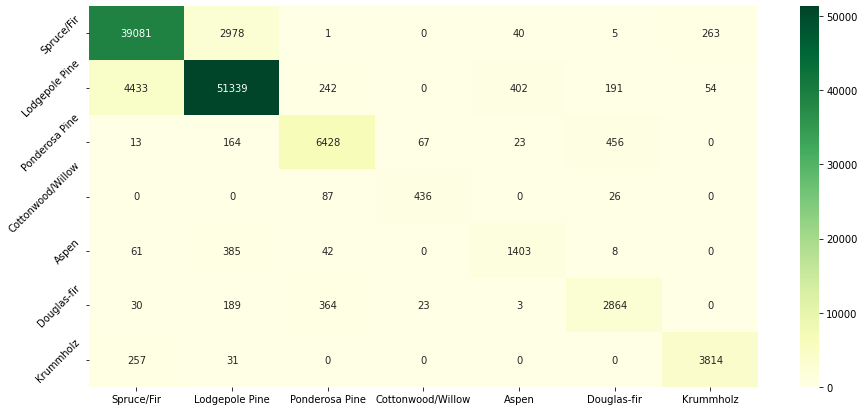

In [79]:
matrix = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(matrix, fmt='g', annot = True, cmap='YlGn', xticklabels = types)
ax.yaxis.set_ticklabels(types, rotation=45, horizontalalignment='right')

plt.show()

Majority classes in data set have low percentage of wrong classifications, and as expected for minority forest types like Cottonwood/Willow or Aspen percentage is higher, they are mostly wrongly classified as one of  majority classes, here Spruce/Fir, Lodgpole Pine or  Ponderosa Pine. 
Looking into classification report, although is dataset imbalanced recall and F1-score values look somewhat balanced. 
Maybe the way to go is to check feature collinearity and remove collinear features, thus make model more simple and then check the accuracy?  

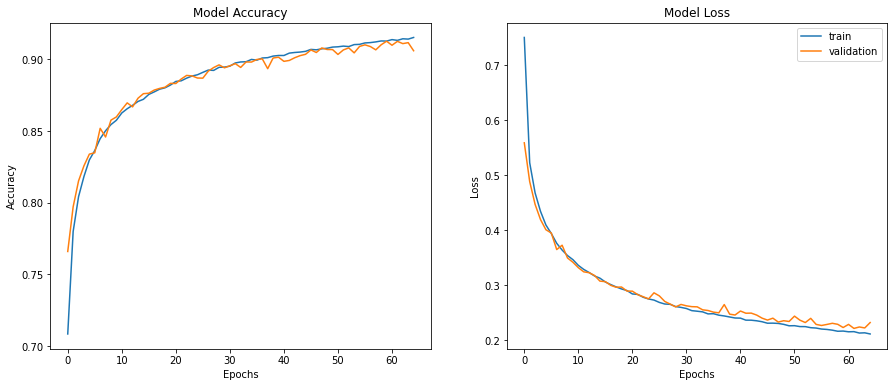

In [78]:
f, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'] )
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

The accuracy and loss slopes are quite good, it seems like that after app 50 epochs model tend to overfit.
Below I'll remove the features which are correlated and build new model to check if performance can be improved  

### Trying another model after removing higly correlated data ###

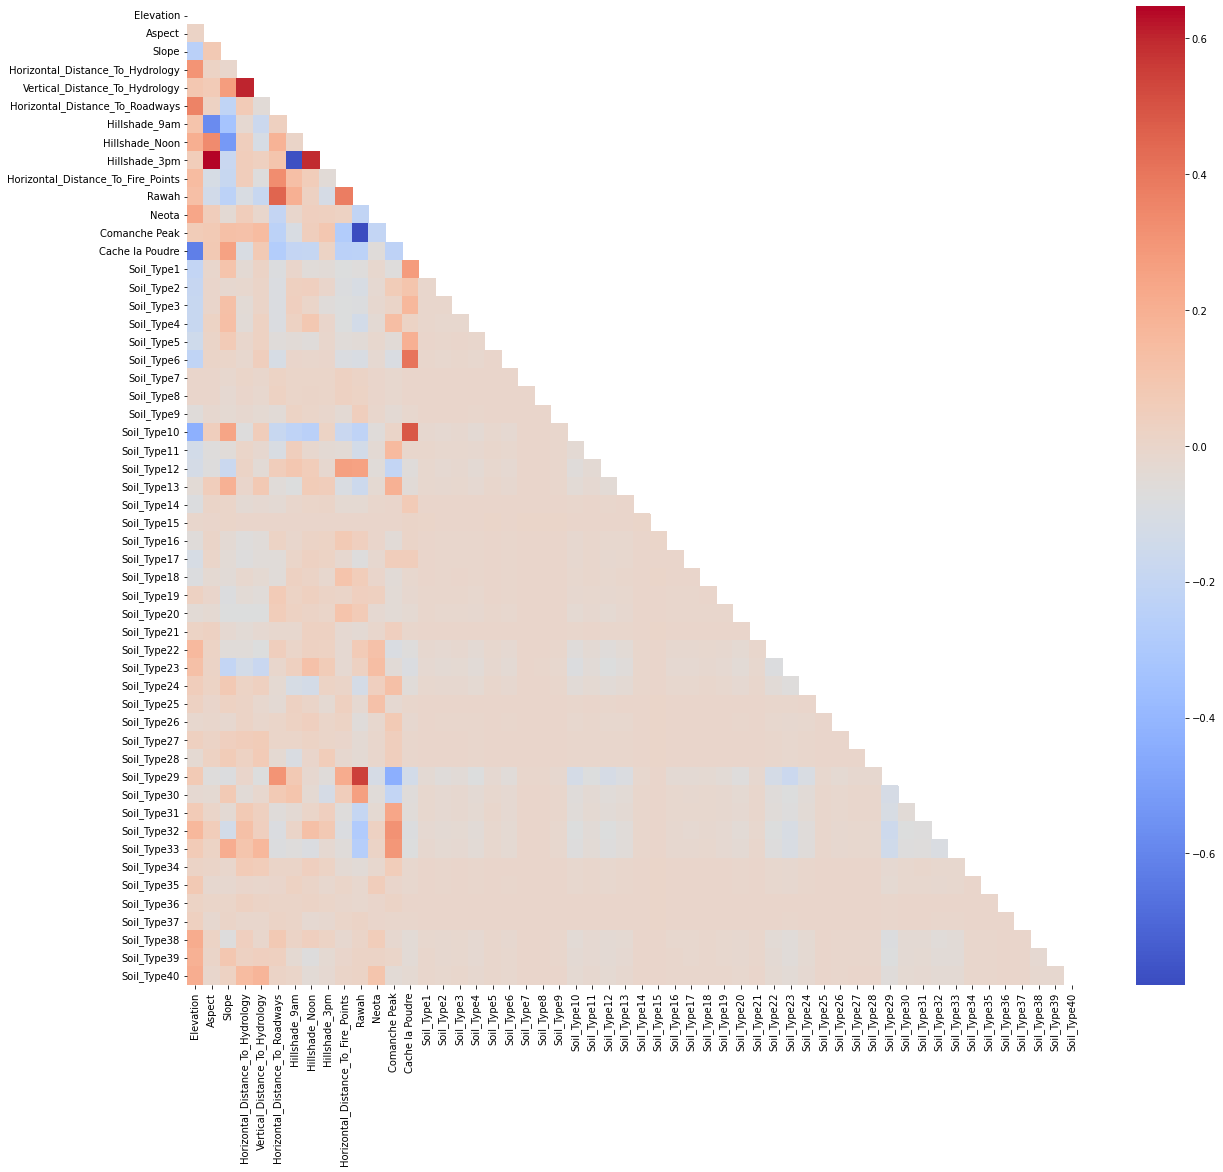

In [68]:
data_corr= data.corr()
f, ax = plt.subplots(figsize=(20,18))
mask = np.zeros_like(data_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data_corr, cmap='coolwarm', mask=mask)
plt.show()

Correlation (app . between 0.2 till 0.7) is observed between:
- Elevation and features like slope, Horisontal distance to Hydrology, Horizontal distance to Roadways , Hillshade Noon, areas Neota and Cache le Poudre (strong)

- Wilderness areas, especially Rawah and Comanche Peak, but other two areas have also some kind of medium correlation (0.2). Rawah and Comanche Peak are highly correlated with soil types 29 - 33. Comanche Peak , Soil types 1 and 6 will be removed . 

- Hillshades at 9am and 3pm and those at noon and 3pm are strongly correlated, therefore we could remove two from 3 . Hillshades seem to be highly correlated with Aspect data, therefore this is another feature to be removed.  



In [69]:
data_clean = data.drop(columns = ['Slope', 'Horizontal_Distance_To_Hydrology','Horizontal_Distance_To_Roadways', 'Hillshade_Noon', 'Hillshade_9am', 'Comanche Peak', 'Soil_Type1', 'Soil_Type6', 'Soil_Type10' ])

In [49]:
features1 = data_clean.drop(columns ='class')
x1_train, x1_test, y1_train, y1_test = train_test_split(features1, labels, test_size= 0.2, stratify = labels, random_state = 27)

x1_train_scaled = normalizer.fit_transform(x1_train)
x1_test_scaled = normalizer.transform(x1_test)

In [53]:
model1 = Sequential()
model1.add(InputLayer(input_shape = (x1_train_scaled.shape[1])))
model1.add(Dense(120, activation='relu'))
model1.add(Dense(82, activation = 'relu'))
model1.add(Dense(42, activation = 'relu'))
model1.add(Dense(20, activation = 'relu'))
model1.add(Dense(8, activation = 'softmax'))
model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 120)               5520      
                                                                 
 dense_27 (Dense)            (None, 82)                9922      
                                                                 
 dense_28 (Dense)            (None, 42)                3486      
                                                                 
 dense_29 (Dense)            (None, 20)                860       
                                                                 
 dense_30 (Dense)            (None, 8)                 168       
                                                                 
Total params: 19,956
Trainable params: 19,956
Non-trainable params: 0
_________________________________________________________________


In [54]:
no_epochs = 188
batch_size = 1000
stop = EarlyStopping(patience = 5, monitor = 'val_accuracy' )
hist1 = model1.fit(x1_train_scaled, y1_train, callbacks =[stop], epochs = no_epochs, batch_size = batch_size, validation_split = 0.1, verbose = 0)

In [55]:
loss1, accuracy1 = model1.evaluate(x1_test_scaled, y1_test, verbose = 0)
print(f'loss: {loss1}')
print(f'accuracy: {accuracy1}')

loss: 0.34938931465148926
accuracy: 0.8516475558280945


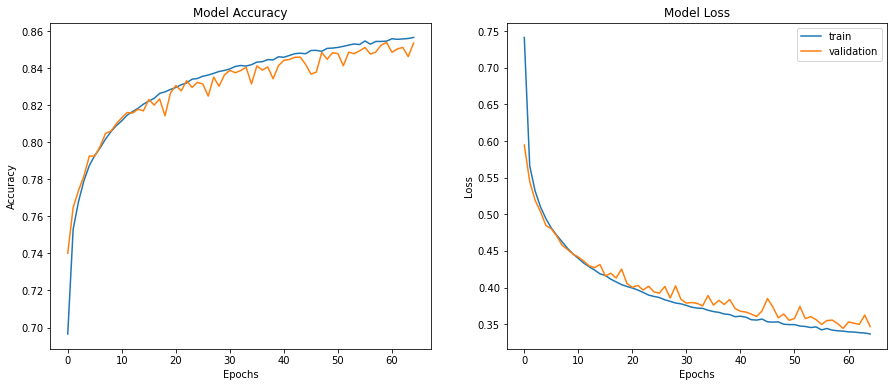

In [56]:
f, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(hist1.history['accuracy'])
ax[0].plot(hist1.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(hist1.history['loss'])
ax[1].plot(hist1.history['val_loss'] )
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

This Model seems to overfit more , it seems like that data set simplification did not help much in model performance.